In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.2 MB/s eta 0:00:00


In [ ]:
import librosa
import torch
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model, AutoConfig

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter

import glob
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip /content/drive/MyDrive/Cust_utt/wavs.zip -d /content/wavs

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = "facebook/wav2vec2-xls-r-300m"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name,).to(device)

Some weights of the model checkpoint at facebook/wav2vec2-xls-r-300m were not used when initializing Wav2Vec2Model: ['quantizer.codevectors', 'project_hid.weight', 'quantizer.weight_proj.weight', 'project_hid.bias', 'project_q.weight', 'quantizer.weight_proj.bias', 'project_q.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Expt. (d): Multi-language (15 audio: 3 language * 5 samples each)

In [ ]:
eng_audios = glob.glob("/content/wavs/wav_data_prod/english_wavs/*")[10:15]
hin_audios = glob.glob("/content/wavs/wav_data_prod/hindi_wavs/*")[:5]
kan_audios = glob.glob("/content/wavs/wav_data_prod/kannada_wavs/*")[:5]
# mal_audios = glob.glob("/content/wavs/wav_data_prod/malayalam_wavs/*")[:100]
# tam_audios = glob.glob("/content/wavs/wav_data_prod/tamil_wavs/*")[:100]
# tel_audios = glob.glob("/content/wavs/wav_data_prod/telugu_wavs/*")[:100]

In [ ]:
res = []
y_res = []
samples = 5

for i in eng_audios:
    input_audio, sample_rate = librosa.load(i,  sr=16000)
    i = feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)
    with torch.no_grad():
        o = model(i.input_values.to(device), output_hidden_states=True)
    x = o.last_hidden_state[0].cpu().numpy()
    new_frames = int(len(input_audio)/(16000*.8))
    x = x[:new_frames*40]
    reshaped_arr = x.reshape(40, new_frames, 1024)
    y_res.append(new_frames)
    concatenated_arr = np.concatenate(reshaped_arr, axis=1)
    res.append(concatenated_arr)


for i in hin_audios:
    input_audio, sample_rate = librosa.load(i,  sr=16000)
    i = feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)
    with torch.no_grad():
        o = model(i.input_values.to(device), output_hidden_states=True)
    x = o.last_hidden_state[0].cpu().numpy()
    new_frames = int(len(input_audio)/(16000*.8))
    x = x[:new_frames*40]
    reshaped_arr = x.reshape(40, new_frames, 1024)
    y_res.append(new_frames)
    concatenated_arr = np.concatenate(reshaped_arr, axis=1)
    res.append(concatenated_arr)


for i in kan_audios:
    input_audio, sample_rate = librosa.load(i,  sr=16000)
    i = feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)
    with torch.no_grad():
        o = model(i.input_values.to(device), output_hidden_states=True)
    x = o.last_hidden_state[0].cpu().numpy()
    new_frames = int(len(input_audio)/(16000*.8))
    x = x[:new_frames*40]
    reshaped_arr = x.reshape(40, new_frames, 1024)
    y_res.append(new_frames)
    concatenated_arr = np.concatenate(reshaped_arr, axis=1)
    res.append(concatenated_arr)

In [ ]:
print(y_res, sum(y_res))
print([i.shape[0] for i in res])
len(y_res), len(res)

[41, 43, 47, 43, 82, 32, 82, 62, 70, 71, 33, 49, 57, 63, 40] 815
[41, 43, 47, 43, 82, 32, 82, 62, 70, 71, 33, 49, 57, 63, 40]


(15, 15)

In [ ]:
y_si = []
y_lid = []

for i in range(len(y_res)):
    y_si += [i]*y_res[i]
    y_lid += [i//samples]*y_res[i]

print(len(y_si), len(y_lid))
len(set(y_si)), len(set(y_lid))

815 815


(15, 3)

In [ ]:
X = res[0]
for i in res[1:]:
    X = np.vstack((X, i))

print(X.shape)

(815, 40960)


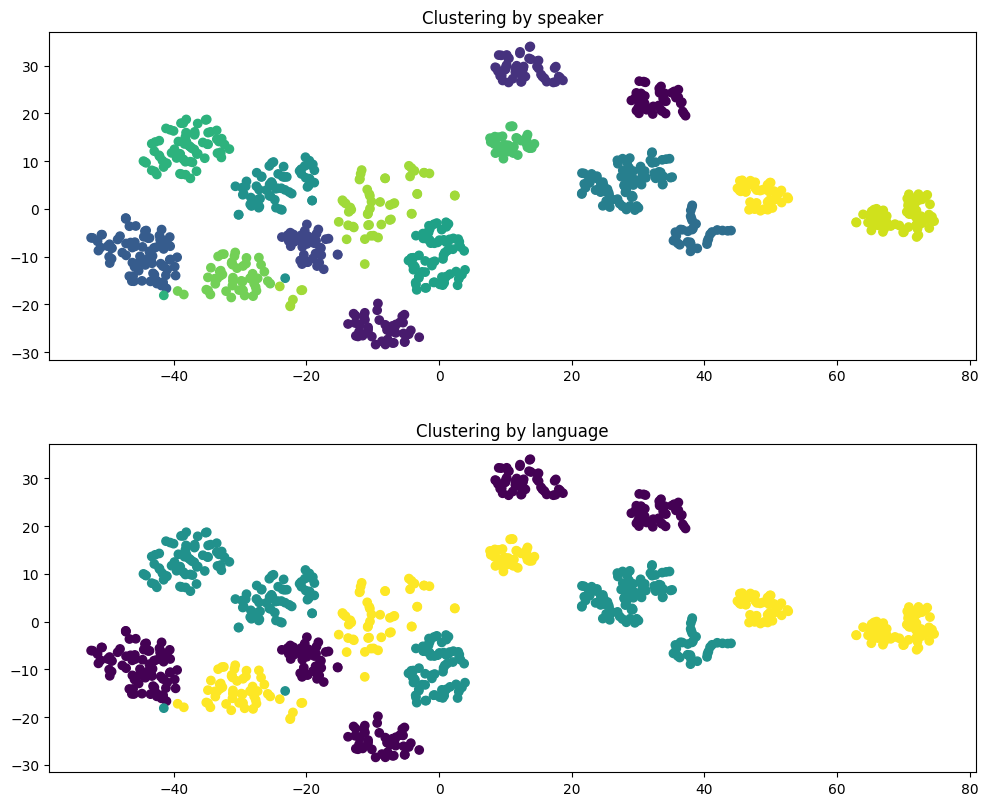

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
tsne.kl_divergence_


fig, ax = plt.subplots(2, figsize = (10,8))
fig.tight_layout(h_pad=4)
ax[0].scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], c=y_si, cmap='viridis')
ax[0].set_title('Clustering by speaker')
ax[1].scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], c=y_lid, cmap='viridis')
ax[1].set_title('Clustering by language')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_lid, test_size=.2)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.9877300613496932

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

scaling = StandardScaler()
 
# Use fit and transform method
scaling.fit(X)
scaled_data = scaling.transform(X)
 
principal = PCA(n_components=10)
principal.fit(scaled_data)
x = principal.transform(scaled_data)

X_train, X_test, y_train, y_test = train_test_split(x, y_lid, test_size=.2)


clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

accuracy_score(y_test, predictions)

1.0

In [ ]:
from IPython.display import Audio

path = '/content/drive/MyDrive/Cust_utt/aud2.wav'
Audio(path, autoplay=True)

#### Expt. (e): Clustering Multilingual Audio (Code-Switching)

In [ ]:
f = ['/content/drive/MyDrive/Cust_utt/aud1.wav', '/content/drive/MyDrive/Cust_utt/aud2.wav']
res = []

for i in f:
    input_audio, sample_rate = librosa.load(i,  sr=16000)
    i = feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)
    with torch.no_grad():
        o = model(i.input_values.to(device), output_hidden_states=True)
    x = o.last_hidden_state[0].cpu().numpy()
    new_frames = int(len(input_audio)/(16000*.8))
    x = x[:new_frames*40]
    reshaped_arr = x.reshape(40, new_frames, 1024)
    concatenated_arr = np.concatenate(reshaped_arr, axis=1)
    res.append(concatenated_arr)

In [ ]:
X = res[0]
for i in res[1:]:
    X = np.vstack((X, i))

print(X.shape)

(22, 40960)


In [ ]:
'''
'/content/drive/MyDrive/Cust_utt/aud1.wav' 
0.0-3.2 [1]*4+[0]*3+[2]*3
5.6-9.0
'/content/drive/MyDrive/Cust_utt/aud2.wav' 

0.0 - 4.0 [1]*5+[0]*3+[2]*3+[0]
6.4 - 9.2

'''

In [ ]:
y_lid = [1]*4+[0]*3+[2]*3 + [1]*5+[0]*3+[2]*3+[0]   # Language label
y_sid = [0]*10 + [1]*12     # Speaker label

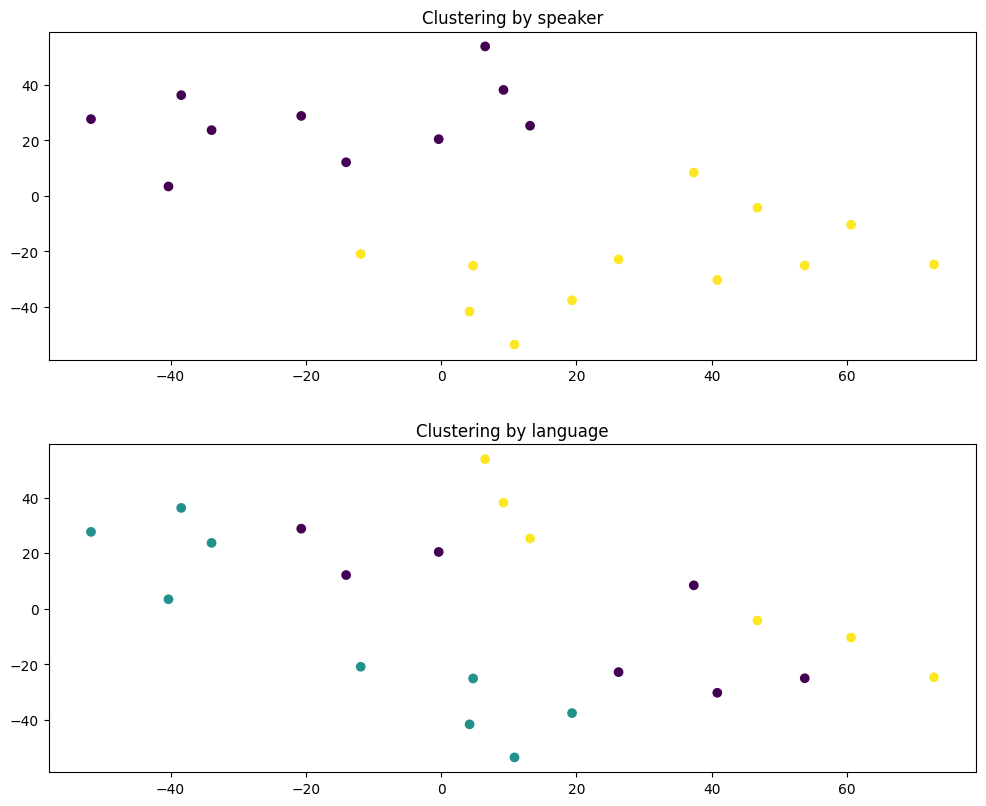

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
X_tsne = tsne.fit_transform(X)
tsne.kl_divergence_


fig, ax = plt.subplots(2, figsize = (10,8))
fig.tight_layout(h_pad=4)
ax[0].scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], c=y_sid, cmap='viridis')
ax[0].set_title('Clustering by speaker')
ax[1].scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], c=y_lid, cmap='viridis')
ax[1].set_title('Clustering by language')
plt.show()

#### Using VAD to determine regions of speech

In [ ]:
import numpy as np
import scipy.io.wavfile as wf
import matplotlib.pyplot as plt

class VoiceActivityDetector():
    """ Use signal energy to detect voice activity in wav file """
    
    def __init__(self, wave_input_filename):
        self._read_wav(wave_input_filename)._convert_to_mono()
        self.sample_window = 0.02 #20 ms
        self.sample_overlap = 0.01 #10ms
        self.speech_window = 0.5 #half a second
        self.speech_energy_threshold = 0.6 #60% of energy in voice band
        self.speech_start_band = 300
        self.speech_end_band = 3000
           
    def _read_wav(self, wave_file):
        self.rate, self.data = wf.read(wave_file)
        self.channels = len(self.data.shape)
        self.filename = wave_file
        return self
    
    def _convert_to_mono(self):
        if self.channels == 2 :
            self.data = np.mean(self.data, axis=1, dtype=self.data.dtype)
            self.channels = 1
        return self
    
    def _calculate_frequencies(self, audio_data):
        data_freq = np.fft.fftfreq(len(audio_data),1.0/self.rate)
        data_freq = data_freq[1:]
        return data_freq    
    
    def _calculate_amplitude(self, audio_data):
        data_ampl = np.abs(np.fft.fft(audio_data))
        data_ampl = data_ampl[1:]
        return data_ampl
        
    def _calculate_energy(self, data):
        data_amplitude = self._calculate_amplitude(data)
        data_energy = data_amplitude ** 2
        return data_energy
        
    def _znormalize_energy(self, data_energy):
        energy_mean = np.mean(data_energy)
        energy_std = np.std(data_energy)
        energy_znorm = (data_energy - energy_mean) / energy_std
        return energy_znorm
    
    def _connect_energy_with_frequencies(self, data_freq, data_energy):
        energy_freq = {}
        for (i, freq) in enumerate(data_freq):
            if abs(freq) not in energy_freq:
                energy_freq[abs(freq)] = data_energy[i] * 2
        return energy_freq
    
    def _calculate_normalized_energy(self, data):
        data_freq = self._calculate_frequencies(data)
        data_energy = self._calculate_energy(data)
        #data_energy = self._znormalize_energy(data_energy) #znorm brings worse results
        energy_freq = self._connect_energy_with_frequencies(data_freq, data_energy)
        return energy_freq
    
    def _sum_energy_in_band(self,energy_frequencies, start_band, end_band):
        sum_energy = 0
        for f in energy_frequencies.keys():
            if start_band<f<end_band:
                sum_energy += energy_frequencies[f]
        return sum_energy
    
    def _median_filter (self, x, k):
        assert k % 2 == 1, "Median filter length must be odd."
        assert x.ndim == 1, "Input must be one-dimensional."
        k2 = (k - 1) // 2
        y = np.zeros ((len (x), k), dtype=x.dtype)
        y[:,k2] = x
        for i in range (k2):
            j = k2 - i
            y[j:,i] = x[:-j]
            y[:j,i] = x[0]
            y[:-j,-(i+1)] = x[j:]
            y[-j:,-(i+1)] = x[-1]
        return np.median (y, axis=1)
        
    def _smooth_speech_detection(self, detected_windows):
        median_window=int(self.speech_window/self.sample_window)
        if median_window%2==0: median_window=median_window-1
        median_energy = self._median_filter(detected_windows[:,1], median_window)
        return median_energy
        
    def convert_windows_to_readible_labels(self, detected_windows):
        """ Takes as input array of window numbers and speech flags from speech
        detection and convert speech flags to time intervals of speech.
        Output is array of dictionaries with speech intervals.
        """
        speech_time = []
        is_speech = 0
        for window in detected_windows:
            if (window[1]==1.0 and is_speech==0): 
                is_speech = 1
                speech_label = {}
                speech_time_start = window[0] / self.rate
                speech_label['speech_begin'] = speech_time_start
                print(window[0], speech_time_start)
                #speech_time.append(speech_label)
            if (window[1]==0.0 and is_speech==1):
                is_speech = 0
                speech_time_end = window[0] / self.rate
                speech_label['speech_end'] = speech_time_end
                speech_time.append(speech_label)
                print(window[0], speech_time_end)
        return speech_time
      
    def plot_detected_speech_regions(self):
        """ Performs speech detection and plot original signal and speech regions.
        """
        data = self.data
        detected_windows = self.detect_speech()
        data_speech = np.zeros(len(data))
        it = np.nditer(detected_windows[:,0], flags=['f_index'])
        while not it.finished:
            data_speech[int(it[0])] = data[int(it[0])] * detected_windows[it.index,1]
            it.iternext()
        plt.figure()
        plt.plot(data_speech)
        plt.plot(data)
        plt.show()
        return self
       
    def detect_speech(self):
        """ Detects speech regions based on ratio between speech band energy
        and total energy.
        Output is array of window numbers and speech flags (1 - speech, 0 - nonspeech).
        """
        detected_windows = np.array([])
        sample_window = int(self.rate * self.sample_window)
        sample_overlap = int(self.rate * self.sample_overlap)
        data = self.data
        sample_start = 0
        start_band = self.speech_start_band
        end_band = self.speech_end_band
        while (sample_start < (len(data) - sample_window)):
            sample_end = sample_start + sample_window
            if sample_end>=len(data): sample_end = len(data)-1
            data_window = data[sample_start:sample_end]
            energy_freq = self._calculate_normalized_energy(data_window)
            sum_voice_energy = self._sum_energy_in_band(energy_freq, start_band, end_band)
            sum_full_energy = sum(energy_freq.values())
            speech_ratio = sum_voice_energy/sum_full_energy
            # Hipothesis is that when there is a speech sequence we have ratio of energies more than Threshold
            speech_ratio = speech_ratio>self.speech_energy_threshold
            detected_windows = np.append(detected_windows,[sample_start, speech_ratio])
            sample_start += sample_overlap
        detected_windows = detected_windows.reshape(int(len(detected_windows)/2),2)
        detected_windows[:,1] = self._smooth_speech_detection(detected_windows)
        return detected_windows
 
v = VoiceActivityDetector(path)
v.convert_windows_to_readible_labels(v.detect_speech())

<ipython-input-14-b1c9e786e2ed>:149: RuntimeWarning: invalid value encountered in double_scalars
  speech_ratio = sum_voice_energy/sum_full_energy


10560.0 0.33
22400.0 0.7
35520.0 1.11
38400.0 1.2
48960.0 1.53
50240.0 1.57
68480.0 2.14
73280.0 2.29
96000.0 3.0
105600.0 3.3
185600.0 5.8
192640.0 6.02
200640.0 6.27
202880.0 6.34
204480.0 6.39
207360.0 6.48
223040.0 6.97
224640.0 7.02
226880.0 7.09
239040.0 7.47
242240.0 7.57
245120.0 7.66
247360.0 7.73
258560.0 8.08
275520.0 8.61


[{'speech_begin': 0.33, 'speech_end': 0.7},
 {'speech_begin': 1.11, 'speech_end': 1.2},
 {'speech_begin': 1.53, 'speech_end': 1.57},
 {'speech_begin': 2.14, 'speech_end': 2.29},
 {'speech_begin': 3.0, 'speech_end': 3.3},
 {'speech_begin': 5.8, 'speech_end': 6.02},
 {'speech_begin': 6.27, 'speech_end': 6.34},
 {'speech_begin': 6.39, 'speech_end': 6.48},
 {'speech_begin': 6.97, 'speech_end': 7.02},
 {'speech_begin': 7.09, 'speech_end': 7.47},
 {'speech_begin': 7.57, 'speech_end': 7.66},
 {'speech_begin': 7.73, 'speech_end': 8.08}]

In [ ]:
from IPython.display import Audio
Audio(path, autoplay=True)

Audio length in miliseconds: 32000\
No of frames: 1608\
Frame chunk length: 43000/2134 = 20ms

In [ ]:
print(Counter(cluster_pred))

Counter({0: 21, 1: 19})


#### Annotating Segments of Silence and Speech

In [ ]:
'''
Audio Segments:

4.6 - 5.4: 800 ms = 800/20 = 40 frames
21.6 - 24.0:  2400 ms =  2400/20 = 120 frames
[0]*5 + [1]*2 + [0]*20 + [1]*6 + [0]*7

Ratio of speech to silence: 120/2134 = 0.056 = 0.06
Clustering ratio: 


En: # 1: /content/wavs/wav_data_prod/english_wavs/69aeba27-c363-40b0-9bf4-1d31077482bd.wav

19.8-20.2 [0]*26+[1]*1+[0]*31+[1]*1+[0]*24 = 83
46.8-47.0


#2: /content/wavs/wav_data_prod/english_wavs/78c20281-030d-4df9-b448-6cb175fb7eef.wav

 0.8 -  1.8 [0]*1+[1]*1+[0]*25+[1]*4+[0]*1+[1]*1+[0]*5+[1]*1+[0]*4 = 43
22.0 - 24.4
25.8 - 26.0
30.8 - 31.2


#3: /content/wavs/wav_data_prod/english_wavs/b0e63254-d623-4706-94cb-d996050e6925.wav

28.0 - 29.4 [0]*35+[1]*2+[0]*8 = 45


#4: /content/wavs/wav_data_prod/english_wavs/fb42e0c2-e7a7-4dc3-9645-197790e8a13f.wav

 0.8 -  1.6 [0]+[1]+[0]+[1]*5+[0]*3+[1]*2+[0]*35+[1]*3+[0]*21 = 72
 2.6 -  6.6
 9.0 - 10.2
38.6 - 40.6


#5: /content/wavs/wav_data_prod/english_wavs/4782d310-1985-4175-ae19-17e5769e9ef0.wav

20.6 - 21.8 [0]*25+[1]*3+[0]*7+[1]*1+[0]*8 = 44
28.0 - 28.2


#6: /content/wavs/wav_data_prod/english_wavs/44256ea1-8582-43ba-a30c-36c89bb9d56e.wav

 3.0 -  3.4 [0]*3+[1]*1+[0]*13+[1]*2+[0]*15+[1]*4+[0]*9 = 47
14.0 - 14.8
27.4 - 28.0


Hi: #1: /content/wavs/wav_data_prod/hindi_wavs/4aa2751c-3581-442c-81c8-c589dabd6e5c.wav

 1.0 -  1.8 [0]+[2]+[0]*24+[2]*4+[0]*3 = 33
21.2 - 23.8


'''





In [ ]:
# y = [0]*26+[1]*1+[0]*31+[1]*1+[0]*24 + [0]*1+[1]*1+[0]*25+[1]*4+[0]*1+[1]*1+[0]*5+[1]*1+[0]*4 + [0]*35+[1]*2+[0]*8 + [0]+[1]+[0]+[1]*5+[0]*3+[1]*2+[0]*35+[1]*3+[0]*21 + [0]*25+[1]*3+[0]*7+[1]*1+[0]*8 + [0]*3+[1]*1+[0]*13+[1]*2+[0]*15+[1]*4+[0]*9     # Labels for 6 audio expt
y = [0]*25+[1]*3+[0]*7+[1]*1+[0]*8 + [0]+[2]+[0]*24+[2]*4+[0]*3     # Labels for Eng-Hin (2 audio expt)
len(y)

77

In [ ]:
X_arr[3]

array([-0.10143478, -0.1300841 , -0.02126723, ..., -0.079183  ,
        0.09153485,  0.4169956 ], dtype=float32)

In [ ]:
files = ['/content/wavs/wav_data_prod/english_wavs/4782d310-1985-4175-ae19-17e5769e9ef0.wav', '/content/wavs/wav_data_prod/hindi_wavs/4aa2751c-3581-442c-81c8-c589dabd6e5c.wav']

In [ ]:
input_audio, sample_rate = librosa.load(files[1],  sr=16000)
i = feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)
with torch.no_grad():
    o = model(i.input_values.to(device), output_hidden_states=True)
x = o.last_hidden_state[0].cpu().numpy()
x = x[:1320]
reshaped_arr = x.reshape(40, 33, 1024)
concatenated_arr = np.concatenate(reshaped_arr, axis=1)
concatenated_arr.shape
# print(x.shape)

(33, 40960)

In [ ]:
X += [concatenated_arr]
X[1].shape

(33, 40960)

In [ ]:
X_arr = X[0]
for i in X[1:]:
    X_arr = np.vstack((X_arr, i))

print(X_arr.shape)

(77, 40960)


In [ ]:
input_audio, sample_rate = librosa.load(eng_audios[0],  sr=16000)
i = feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)
with torch.no_grad():
    o = model(i.input_values.to(device), output_hidden_states=True)

In [ ]:
# Clubbing 40 frames together
# Therefore intervals are: 40*20 ms each = 800 ms ( 32000 ms / 40 parts = 800 ms)
X = o.last_hidden_state[0].cpu().numpy()
X = X[:1600]
reshaped_arr = X.reshape(40, 40, 1024)
concatenated_arr = np.concatenate(reshaped_arr, axis=1)
concatenated_arr.shape

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_arr)
tsne.kl_divergence_

0.2157610058784485

In [ ]:
kmeans = KMeans(
        init="random",
        n_clusters=3,
        n_init=10,
        max_iter=300,
        random_state=42
    )

kmeans.fit(X_arr)
cluster_pred = kmeans.labels_

In [ ]:
y = [0]*5 + [1]*2 + [0]*20 + [1]*6 + [0]*7

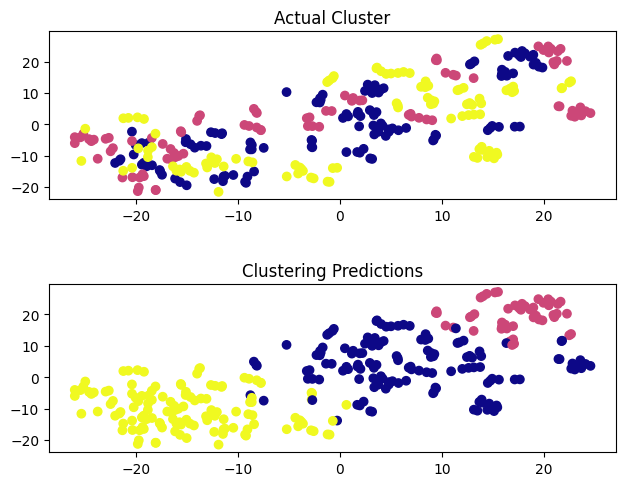

In [ ]:
fig, ax = plt.subplots(2)
fig.tight_layout(h_pad=4)
ax[0].scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], c=y, cmap='plasma')
ax[0].set_title('Actual Cluster')
ax[1].scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], c=cluster_pred, cmap='plasma')
ax[1].set_title('Clustering Predictions')
plt.show()

In [ ]:
o.last_hidden_state[0].shape

torch.Size([1608, 1024])

#### DBSCAN clustering

In [ ]:
kmeans = KMeans(
        init="random",
        n_clusters=2,
        n_init=10,
        max_iter=300,
        random_state=42
    )

kmeans.fit(X)
cluster_pred = kmeans.labels_

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
tsne.kl_divergence_

0.9539809226989746

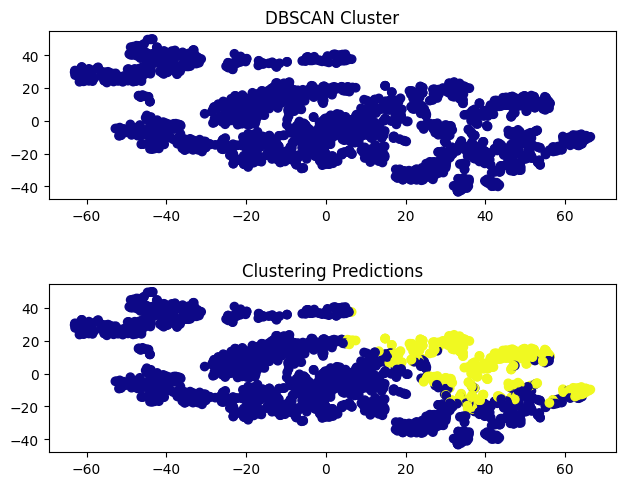

In [ ]:
fig, ax = plt.subplots(2)
fig.tight_layout(h_pad=4)
ax[0].scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], c=db_cluster, cmap='plasma')
ax[0].set_title('DBSCAN Cluster')
ax[1].scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], c=y, cmap='plasma')
ax[1].set_title('Clustering Predictions')
plt.show()

### Taking 100 audios each (for 6 languages) |for LID Clustering with 4 strategies:

1.   Max Pooling
2.   Mean Pooling
3.   Sum Pooling
4.   Mel Spectrogram



In [ ]:
eng_audios = glob.glob("/content/wavs/wav_data_prod/english_wavs/*")[:100]
hin_audios = glob.glob("/content/wavs/wav_data_prod/hindi_wavs/*")[:100]
kan_audios = glob.glob("/content/wavs/wav_data_prod/kannada_wavs/*")[:100]
mal_audios = glob.glob("/content/wavs/wav_data_prod/malayalam_wavs/*")[:100]
tam_audios = glob.glob("/content/wavs/wav_data_prod/tamil_wavs/*")[:100]
tel_audios = glob.glob("/content/wavs/wav_data_prod/telugu_wavs/*")[:100]

In [ ]:
input_audio, sample_rate = librosa.load(f,  sr=16000)
mel = np.mean(librosa.feature.melspectrogram(y=input_audio, sr=sample_rate, n_fft=1000).T, axis=0)
mel.shape

(128,)

In [ ]:
f = eng_audios[0]
input_audio, sample_rate = librosa.load(f,  sr=16000)
i = feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)
o = model(i.input_values.to(device), output_hidden_states=True)
outputs = torch.mean(o[0], dim=1)

In [ ]:
outputs.reshape(1024).shape

In [ ]:
lst = []
for file in eng_audios:
    input_audio, sample_rate = librosa.load(file,  sr=16000)
    # mel = np.mean(librosa.feature.melspectrogram(y=input_audio, sr=sample_rate, n_fft=1000).T, axis=0)
    # lst.append(mel)
    i = feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)
    with torch.no_grad():
        o = model(i.input_values.to(device), output_hidden_states=True)
    lst.append(torch.mean(o[0], dim=1).reshape(1024))    
#     lst.append(torch.sum(o.last_hidden_state[0], dim=0))    
#     lst.append(torch.max(o.last_hidden_state[0], dim=0)[0])  

In [ ]:
for file in hin_audios:
    input_audio, sample_rate = librosa.load(file,  sr=16000)
    # mel = np.mean(librosa.feature.melspectrogram(y=input_audio, sr=sample_rate, n_fft=1000).T, axis=0)      # MelSpectrogram Features
    # lst.append(mel)
    i = feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)        # Preprocessing for wav2vec
    with torch.no_grad():
        o = model(i.input_values.to(device), output_hidden_states=True)       # Generate embeddings
    lst.append(torch.mean(o[0], dim=1).reshape(1024))         # Mean Pooling
#     lst.append(torch.sum(o.last_hidden_state[0], dim=0))      # Sum Pooling
#     lst.append(torch.max(o.last_hidden_state[0], dim=0)[0])   # Max Pooling

In [ ]:
for file in kan_audios:
    input_audio, sample_rate = librosa.load(file,  sr=16000)
    # mel = np.mean(librosa.feature.melspectrogram(y=input_audio, sr=sample_rate, n_fft=1000).T, axis=0)
    # lst.append(mel)
    i = feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)
    with torch.no_grad():
        o = model(i.input_values.to(device), output_hidden_states=True)
    lst.append(torch.mean(o[0], dim=1).reshape(1024))    
#     lst.append(torch.sum(o.last_hidden_state[0], dim=0))    
#     lst.append(torch.max(o.last_hidden_state[0], dim=0)[0])

In [ ]:
for file in mal_audios:
    input_audio, sample_rate = librosa.load(file,  sr=16000)
    i = feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)
    with torch.no_grad():
        o = model(i.input_values.to(device), output_hidden_states=True)
    lst.append(torch.mean(o[0], dim=1).reshape(1024))

for file in tam_audios:
    input_audio, sample_rate = librosa.load(file,  sr=16000)
    i = feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)
    with torch.no_grad():
        o = model(i.input_values.to(device), output_hidden_states=True)
    lst.append(torch.mean(o[0], dim=1).reshape(1024))    

for file in tel_audios:
    input_audio, sample_rate = librosa.load(file,  sr=16000)
    i = feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)
    with torch.no_grad():
        o = model(i.input_values.to(device), output_hidden_states=True)
    lst.append(torch.mean(o[0], dim=1).reshape(1024))    

In [ ]:
# X = [i.cpu().numpy() for i in lst]
X = lst
y = [0]*100+[1]*100+[2]*100+[3]*100+[4]*100+[5]*100

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Using KMeans to verify whether t-SNE is accurately representing the embeddings.

In [ ]:
kmeans = KMeans(
        init="random",
        n_clusters=6,
        n_init=10,
        max_iter=300,
        random_state=42
    )

kmeans.fit(X)
cluster_pred = kmeans.labels_

#### Using t-SNE for Dim. Red.

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(np.asarray(X))
tsne.kl_divergence_

0.9071595668792725

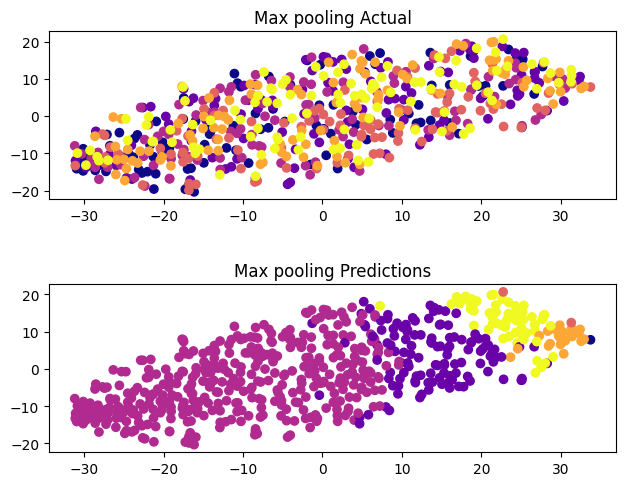

In [ ]:
fig, ax = plt.subplots(2)
fig.tight_layout(h_pad=4)
ax[0].scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], c=y, cmap='plasma')
ax[0].set_title('Max pooling Actual')
ax[1].scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], c=cluster_pred, cmap='plasma')
ax[1].set_title('Max pooling Predictions')
plt.show()

#### Using PCA for Dim. Red.

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(np.asarray(X))

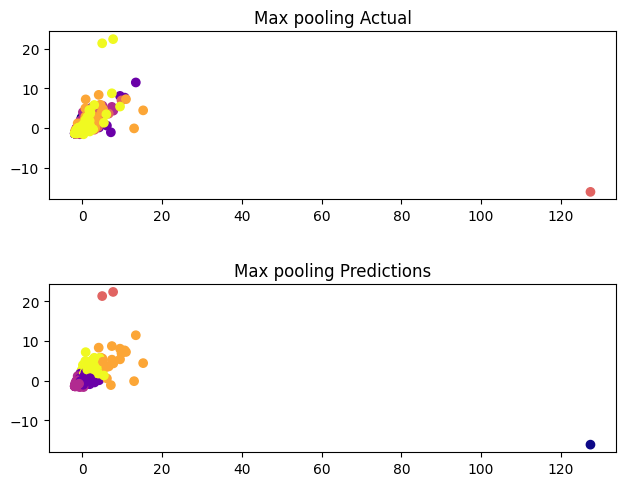

In [ ]:
fig, ax = plt.subplots(2)
fig.tight_layout(h_pad=4)
ax[0].scatter(x=X_pca[:, 0], y=X_pca[:, 1], c=y, cmap='plasma')
ax[0].set_title('Max pooling Actual')
ax[1].scatter(x=X_pca[:, 0], y=X_pca[:, 1], c=cluster_pred, cmap='plasma')
ax[1].set_title('Max pooling Predictions')
plt.show()

KNeighborsClassifier(n_neighbors=3)

0.8823529411764706

In [ ]:
with torch.no_grad():
  o= model(i.input_values, output_hidden_states=True)
print(o.keys())
print(o.last_hidden_state.shape)
print(o.extract_features.shape)

odict_keys(['last_hidden_state', 'extract_features', 'hidden_states'])
torch.Size([1, 2130, 1024])
torch.Size([1, 2130, 512])


In [ ]:
o.last_hidden_state

tensor([[[-0.1005,  0.2563,  0.0801,  ..., -0.0715,  0.0131, -0.0489],
         [-0.0338,  0.2014,  0.0024,  ..., -0.0895,  0.0179, -0.0258],
         [-0.0338,  0.2022,  0.0023,  ..., -0.0891,  0.0171, -0.0259],
         ...,
         [-0.0304,  0.2101,  0.0017,  ..., -0.0888,  0.0150, -0.0245],
         [-0.0189,  0.2799,  0.0184,  ..., -0.0697,  0.0096, -0.0351],
         [-0.0323,  0.2011,  0.0025,  ..., -0.0900,  0.0175, -0.0256]]])

In [ ]:
len(input_audio)//320

1501

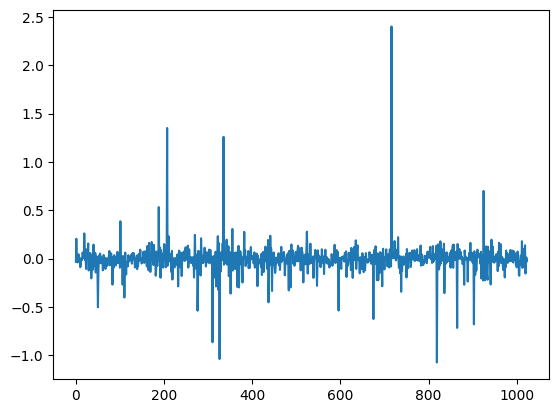

In [ ]:
plt.plot(torch.mean(o.last_hidden_state[0], dim=0))

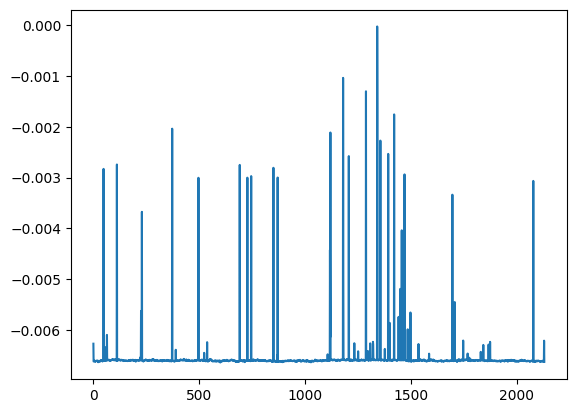

In [ ]:
plt.plot(torch.mean(o.last_hidden_state[0], dim=1))

In [ ]:
o.last_hidden_state[0][0,:].mean()

tensor(-0.0063)

In [ ]:
from IPython.display import Audio 
Audio(kan_audios[-1], autoplay=True)

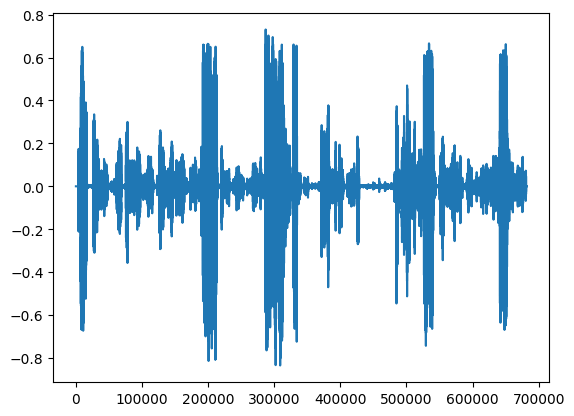

In [ ]:
plt.plot(input_audio)